# Cleanning notebook 

In this notebook, the goal is to import and clean the data from the open food tack project. 
Note that I have written in bold the possible extensions in the description text, all along the notebook.

Let's first call the libraries I'll use : 

In [8]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import sklearn
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

# 1. Import data : 

I have decided to extract the data labeled with the french nutriscore, to set a cleanning method and then decide the application I want to propose. I have in a first place look at a small subset extracted with the website interface, then I downloaded the big data they propose ($10^6$ products). 

**Afterwards I would like to fetch from their json API.**

In [9]:
# ## 
# ## SMALL DATA SET (calories > 0)
# ##

# filename = data_path+"openfoodfacts_with_cholesterol.csv"
# df = pd.read_csv(filename,"\t")

In [10]:
##
## THE BIG DATA SET :
##
## lien de telechargement du dataset (3.8 Go): 
## https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv

filename = data_path+"en.openfoodfacts.org.products.csv"

# GET THE NUMBER OF LINES : 
# bash code : cat en.openfoodfacts.org.products.csv | wc -l
# pandas (long to run) : print(pd.read_csv(filename, sep = "\t", usecols = ["code"],dtype = "str", squeeze=True))
with open(filename) as f:
    print("Number of products in the csv :", len(f.readlines())-1)

## GET INDEX OF NUTRI SCORE IN COLUMNS : 
tmp = pd.read_csv(filename, sep = "\t", nrows = 1).columns
col_index = np.where(tmp=="nutrition-score-fr_100g")[0][0]
col_index

## OPEN FILE WITH ITERATOR CHUNKS SELECTING ROWS WITH INFO ON col_index : :
def valid(chunks):
    for chunk in chunks:
        mask = ~chunk.iloc[:,col_index].isna().values
        yield chunk.loc[mask]            
chunksize = 10 ** 4
chunks = pd.read_csv(filename, sep = "\t", low_memory=False, chunksize=chunksize, header=None)
df_original = pd.concat(valid(chunks))
print("Number of variables : ", df_original.shape[1])
print("Number of product selected : ", df_original.shape[0])

Number of products in the csv : 1716277
Number of variables :  184
Number of product selected :  646577


The chunk method does not allow to set header, so let's do it : 

In [11]:
# df = df_original.drop(0, axis=0)
# df.columns = df_original.loc[0,:]
df = pd.DataFrame(df_original.values[1:,:], columns= df_original.iloc[0,:])
n = df.shape[0]
df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,NaN,...,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is huge ({{df.shape[0]}} products).
Let's first work on a sample of size 10 000, and then comment this part : 

In [12]:
df = df.sample(10000, replace = False)
df.shape

(10000, 184)

## 2. Drop columns with too many missing  values : 
Let's remove the variables with too much NaN. First, I remove the columns filled with NaNs (there is no information in them). 

Then, I have chosen to keep the 1st quantile value of the number of NaNs in each variables : 
* if the variable has less NaNs than this quantile, I will estimate the missing value with KNN procedure, 
* else, I drop the corresponding column. 

In [13]:
##
## TACKLE MISSING VALUES 1 (drop col)
##

## DROP COL FILLED WITH NANs
df = df.loc[:,df.isna().sum(axis=0)<n]
print("There are ", sum(df.isna().sum(axis=0)==n), "variables without any information (all NaNs)")

## DROP COL WITH MORE NANs THAN THE MEAN/1st QUANTILE :
nan_repartition = df.isna().sum(axis=0)
# nan_threshold = nan_repartition.quantile(0.25)
nan_threshold = nan_repartition.mean()
print("I drop variables with more than", nan_threshold, "NaNs")
df = df.drop(df.columns[nan_repartition>nan_threshold], axis = 1)
df.describe()

There are  0 variables without any information (all NaNs)
I drop variables with more than 7239.673913043478 NaNs


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,10000,10000,10000,10000,10000,10000,10000,9967,3826,2871,...,9979.0,5882.0,9979.0,9984.0,9984.0,2894.0,2966.0,3733.0,3658.0,10000.0
unique,10000,10000,597,9921,9920,9874,9873,9386,1067,1401,...,1605.0,280.0,1165.0,1558.0,1513.0,461.0,312.0,401.0,494.0,80.0
top,7622210284426,http://world-en.openfoodfacts.org/product/3560...,kiliweb,1489060420,2017-03-09T11:53:40Z,1614416584,2021-02-27T09:03:04Z,Aceite de oliva virgen extra,200 g,Kunststoff,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
freq,1,1,3648,3,3,4,4,16,179,84,...,1433.0,1820.0,1047.0,1143.0,1143.0,1593.0,1865.0,1163.0,1111.0,497.0


# 3. Exploration of the columns values, set types :

Then, I used the description data in https://world.openfoodfacts.org/data/data-fields.txt, to separate the global data frame into sub-frames. 
Note : to transform the .txt into these lists of variables, I used the bash command : 

    cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_field2.txt

In [12]:
from my_preprocess import data_field2
data_field2.list_of_characteristics

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity']

In [13]:
# USE BASH cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_field2.txt
list_of_characteristics = ["code","url","creator","created_t","created_datetime","last_modified_t",
                           "last_modified_datetime","product_name","generic_name","quantity"]
list_of_tags = ["packaging", "packaging_tags", "brands", "brands_tags", "categories",
                "categories_tags", "categories_fr","origins", "origins_tags","manufacturing_places",
                "manufacturing_places_tags", "labels", "labels_tags", "labels_fr", "emb_codes", 
                "emb_codes_tags", "first_packaging_code_geo", "cities", "cities_tags", 
                "purchase_places", "stores", "countries", "countries_tags", "countries_fr"]
list_of_ingredients = ["ingredients_text", "traces", "traces_tags"]
list_of_misc = ["serving_size", "no_nutriments", "additives_n", "additives", "additives_tags", 
                "ingredients_from_palm_oil_n", "ingredients_from_palm_oil", 
                "ingredients_from_palm_oil_tags", "ingredients_that_may_be_from_palm_oil_n", 
                "ingredients_that_may_be_from_palm_oil", "ingredients_that_may_be_from_palm_oil_tags", 
                "nutrition_grade_fr", "main_category", "main_category_fr", "image_url", 
                "image_small_url"]
list_of_nutri_facts = ["energy_100g","energy-kj_100g","energy-kcal_100g","proteins_100g","casein_100g",
                       "serum-proteins_100g","nucleotides_100g","carbohydrates_100g","sugars_100g",
                       "sucrose_100g","glucose_100g","fructose_100g","lactose_100g","maltose_100g",
                       "maltodextrins_100g","starch_100g","polyols_100g","fat_100g","saturated-fat_100g",
                       "butyric-acid_100g","caproic-acid_100g","caprylic-acid_100g","capric-acid_100g",
                       "lauric-acid_100g","myristic-acid_100g","palmitic-acid_100g","stearic-acid_100g",
                       "arachidic-acid_100g","behenic-acid_100g","lignoceric-acid_100g","cerotic-acid_100g",
                       "montanic-acid_100g","melissic-acid_100g","monounsaturated-fat_100g",
                       "polyunsaturated-fat_100g","omega-3-fat_100g","alpha-linolenic-acid_100g",
                       "eicosapentaenoic-acid_100g","docosahexaenoic-acid_100g","omega-6-fat_100g",
                       "linoleic-acid_100g","arachidonic-acid_100g","gamma-linolenic-acid_100g",
                       "dihomo-gamma-linolenic-acid_100g","omega-9-fat_100g","oleic-acid_100g",
                       "elaidic-acid_100g","gondoic-acid_100g","mead-acid_100g","erucic-acid_100g",
                       "nervonic-acid_100g","trans-fat_100g","cholesterol_100g","fiber_100g","sodium_100g",
                       "alcohol_100g","vitamin-a_100g","vitamin-d_100g","vitamin-e_100g","vitamin-k_100g",
                       "vitamin-c_100g","vitamin-b1_100g","vitamin-b2_100g","vitamin-pp_100g",
                       "vitamin-b6_100g","vitamin-b9_100g","vitamin-b12_100g","biotin_100g",
                       "pantothenic-acid_100g","silica_100g","bicarbonate_100g","potassium_100g",
                       "chloride_100g","calcium_100g","phosphorus_100g","iron_100g","magnesium_100g",
                       "zinc_100g","copper_100g","manganese_100g","fluoride_100g","selenium_100g",
                       "chromium_100g","molybdenum_100g","iodine_100g","caffeine_100g","taurine_100g",
                       "ph_100g","fruits-vegetables-nuts_100g","carbon-footprint_100g",
                       "nutrition-score-fr_100g","nutrition-score-uk_100g"]

# dict_list_variables = {"list_of_characteristics":list_of_characteristics,
#                        "list_of_tags":list_of_tags,
#                        "list_of_ingredients":list_of_ingredients,
#                        "list_of_misc" : list_of_misc,
#                        "list_of_nutri_facts" : list_of_nutri_facts}

Then I used this partition to explore the data : these category allowed me to have an idea of the values of each variable in one hand and to determine the good type of each variable (set just after). I used the following functionm changing the category of the varibles. To ease the re-utilisation of this code, I commented the different possibilities : 

In [8]:
def print_values_from_list_of_var(df_,list_of_var):
    for var in list_of_var : 
        if var in df_.columns:
            print("--",var)
            tmp = df_[df_.columns.intersection([var])]
            var_values = tmp.iloc[(~pd.isna(tmp).values)]
            if len(var_values) < 8:
                print("values = ", var_values.values)
            else :
                print("ex of values = ", 
                      np.array(tmp.iloc[(~pd.isna(tmp).values)].sample(n=8).values).transpose()[0])
        else : 
            print("--", var, " : no data")
            
# list_of_var = list_of_characteristics
# list_of_var = list_of_tags
# list_of_var = list_of_ingredients
# list_of_var = list_of_misc
list_of_var = list_of_nutri_facts
print_values_from_list_of_var(df,list_of_var)

-- energy_100g
ex of values =  [471.0 1954.0 1477.0 2314.0 1159.0 893.0 1523.0 1854.0]
-- energy-kj_100g  : no data
-- energy-kcal_100g
ex of values =  [64.0 510.0 116.0 215.0 189.0 223.0 513.0 7.0]
-- proteins_100g
ex of values =  ['3.33' 0.0 4.5 12.0 3.6 0.0 25.0 21.54]
-- casein_100g  : no data
-- serum-proteins_100g  : no data
-- nucleotides_100g  : no data
-- carbohydrates_100g
ex of values =  [54.0 70.3 58.57 54.0 22.73 11.48 0.5 13.0]
-- sugars_100g
ex of values =  [0.6 19.48 32.0 '11.02' 0.8 28.4 0.0 57.14]
-- sucrose_100g  : no data
-- glucose_100g  : no data
-- fructose_100g  : no data
-- lactose_100g  : no data
-- maltose_100g  : no data
-- maltodextrins_100g  : no data
-- starch_100g  : no data
-- polyols_100g  : no data
-- fat_100g
ex of values =  [1.5455 6.2 0.0 1.2 12.5 0.0 12.0 30.56]
-- saturated-fat_100g
ex of values =  [0.1 1.8 19.0 3.92 1.5 29.0 4.4 0.3]
-- butyric-acid_100g  : no data
-- caproic-acid_100g  : no data
-- caprylic-acid_100g  : no data
-- capric-acid_1

This variable-type analysis allowed me to select the non-relevant variables for my study, such as the dates. I have keep some variables like the country or the name of the person that put the product in the database, just for the exercice to clean text data. This subset will be call "data" :

In [9]:
interest_var = pd.Index(["code","product_name","creator","countries","additives_n","ingredients_from_palm_oil_n",
                "ingredients_that_may_be_from_palm_oil_tags"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))

data = df[df.columns.intersection(interest_var)].copy()
# data = data.fillna(pd.NA)

In [10]:
### GESTION DES TYPES DANS DATA !!
## STR 
str_var = list_of_characteristics 
str_var += list_of_tags
str_var += list_of_ingredients
str_var += list_of_misc
str_var = data.columns.intersection(str_var).values
data[str_var] = data[str_var].astype("str")

## FLOATS (and INTs)
float_var = list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n","ingredients_from_palm_oil_n",
              "ingredients_that_may_be_from_palm_oil_tags"]
float_var = data.columns.intersection(float_var).values
data[float_var] = data[float_var].astype("float")

## CATEGORY
data["creator"] = data[["creator","nutrition-score-fr_100g"]].astype("category")
# data.dtypes

Now that the float types are ok, I can call the "describe" method of pandas, to see the summary of the descriptive statistics : 

In [11]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,7339.000000,7339.000000,9343.000000,9976.000000,9976.000000,9976.000000,3577.000000,3639.000000,9971.000000,9976.000000,5855.000000,9975.000000,9985.000000,2873.000000,2918.000000,3667.000000,3604.000000,10000.000000
mean,2.166235,0.019076,284.379351,1177.703159,14.368995,5.139949,0.031282,0.032057,28.972182,13.313495,2.912052,8.396733,0.567100,0.000125,0.006803,0.145822,0.002459,9.048600
std,3.020805,0.139759,200.906403,829.027222,17.948206,7.582489,0.441760,0.621539,27.611964,18.600183,4.509356,8.570939,8.532155,0.000620,0.032495,2.113480,0.037630,8.896637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000
25%,0.000000,0.000000,112.500000,460.000000,1.100000,0.100000,0.000000,0.000000,4.400000,0.900000,0.000000,1.900000,0.036000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,271.000000,1117.000000,7.800000,2.000000,0.000000,0.000000,17.140000,4.100000,1.600000,6.060000,0.237000,0.000000,0.000000,0.036000,0.000940,10.000000
75%,3.000000,0.000000,408.500000,1699.000000,22.707500,7.300000,0.000000,0.024000,53.730000,20.000000,3.600000,12.000000,0.520000,0.000106,0.002900,0.108000,0.002400,16.000000
max,28.000000,2.000000,4614.000000,19305.000000,100.000000,95.000000,17.860000,35.714000,103.500000,103.500000,87.500000,100.000000,717.000000,0.028333,0.990200,110.000000,2.250000,37.000000


# 4. Special column treatment 
## 4. 1. Modification of "ingredients_drom_palm_oil_n" 

This variable was not well documented, my idea is to go back to a simple boolean variable : is there (or not) some ingredients with palm oil ? The issue is that there already exists such a variable. If it is not in my dataset, I create a new variable, if it is, I concat the 2 variables 

In [12]:
############## dev code ###################
##
## 1st idea of code : 
##

data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.insert(loc = data2.columns.get_loc("ingredients_from_palm_oil_n"),
                    column = "ingredients_from_palm_oil",
                    value = 0)
        index_1 = data2[data2["ingredients_from_palm_oil_n"]==1].index
        data2.at[index_1,"ingredients_from_palm_oil"] = 1
        index_nan = data2[pd.isna(data2["ingredients_from_palm_oil_n"])].index
        data2.at[index_nan,"ingredients_from_palm_oil"] = np.nan
        
    data2.drop("ingredients_from_palm_oil_n", axis=1, inplace = True)
data2.iloc[:,3:10]

## 
## after reflexion, better to do modify directly the line :
##

data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.at[data2["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        data2.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)

I decided to modify some of my variables : 
* if there is no "ingredients_from_palm_oil" but a "ingredients_from_palm_oil_n" colunm, I transformed this one into the first one.
* if there is a "ingredients_from_palm_oil" column and a "ingredients_from_palm_oil_n" column, I used the same boolenization and fill the missing values of the first with this.


I start to isolate the code I want to re-use to define my prepocess method **(idea : object oriented programmation)**

In [13]:
def preprocess_data(data):
    if "ingredients_from_palm_oil_n" in data.columns :
        data.at[data["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        if ("ingredients_from_palm_oil" in data.columns) :
            data['ingredients_from_palm_oil'].fillna(data['ingredients_from_palm_oil_n'], inplace=True)
            data.drop("ingredients_from_palm_oil_n", inplace = True, axis = 1)
        else :
            data.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)
## to test, creation of a fictive column :             
# data2 = data.copy()
# data2.at[:,"ingredients_from_palm_oil"] = np.where(data2["nutrition-score-fr_100g"]<0,0,np.nan)
# data2.at[data2["nutrition-score-fr_100g"]>20,"ingredients_from_palm_oil"] = 1

preprocess_data(data)
float_var[float_var=="ingredients_from_palm_oil_n"] = "ingredients_from_palm_oil"

# 5. Errors in numerical data - outliers :

I had so many variables to check ! 
To ease this work, I propose the following procedure :

* 1. graphical reading : to plot the histograms allowed me to pre-select the possible values for each variables. For example, much of the data "_100g" have values above 100, that can not be normal. 
* 2. Put the possible values in a dictonary and ajust it for every variables, to select the outliers or error data. 
* 3. Have a breaf check to be sure that the data I dropped was in deed outliers.


<!-- In the course, they decompose data in 5 classes : 
* lexical errors
* irregularity error
* Formatage error
* Duplicates
* Outliers -->

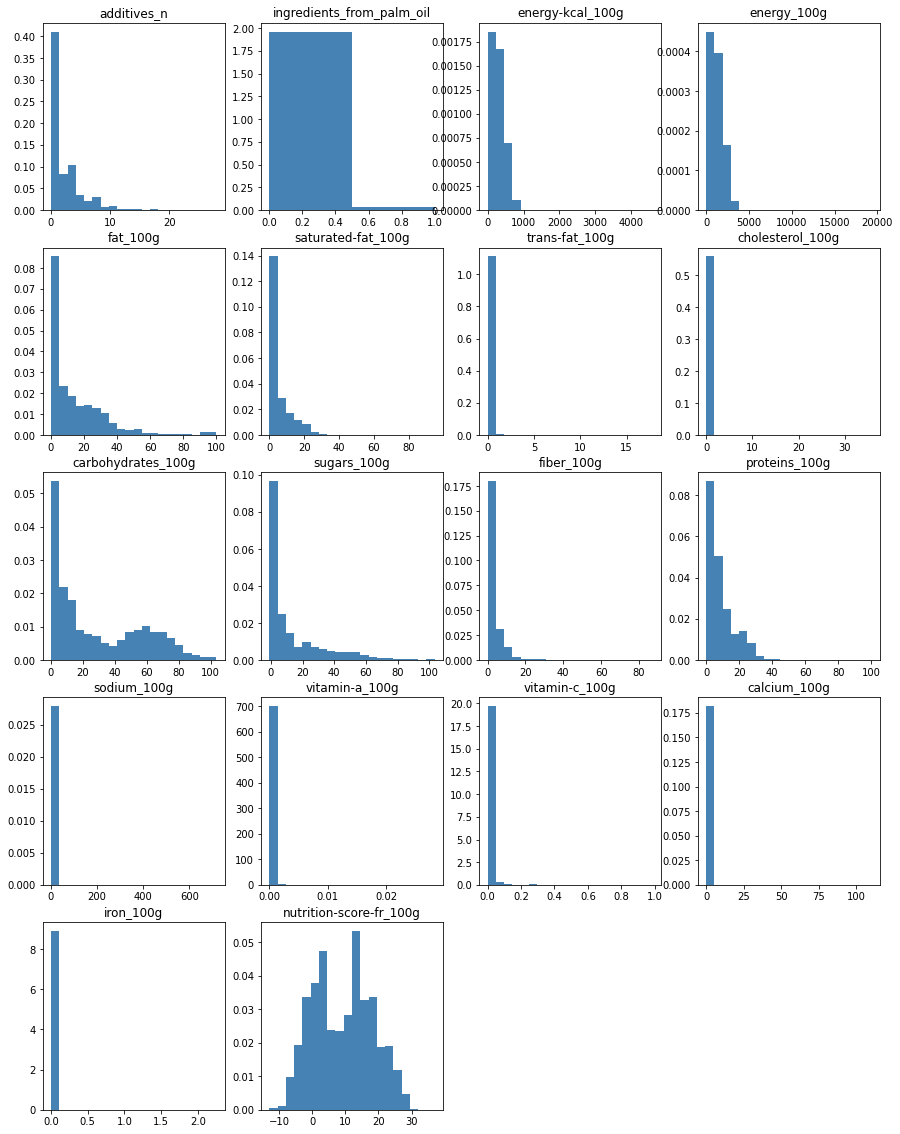

In [14]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

To ease this manual part, I used the following function, that takes the column name, the possible values we want to set, and returns the values that are not in this set of values :

In [15]:
def extract_irreg_errors_val(colname,possible_values, data = data):
    outliers_val = []
    col_values = data[colname].drop_duplicates().values
    ## check possible values : 
    min_value, max_value = possible_values
    for val in col_values :
        if ~np.isnan(val) :
            if (val < min_value) or (val > max_value):
                outliers_val.append(val)
        else : 
            print(sum(data[colname].isna()),"missing values")
    print(len(outliers_val), "item values out of the intervall", possible_values)
    return outliers_val

I made a dictionnary of the possible values each variable can take : 

In [16]:
possible_val_dict = {'additives_n' : [0,35],'ingredients_from_palm_oil': [0,1],
                     'energy-kcal_100g':[0,1500], 'energy_100g':[0,5000],'fat_100g':[0,100],
                     'saturated-fat_100g': [0,100],'trans-fat_100g':[0,90], 'cholesterol_100g':[0,10],
                     'carbohydrates_100g': [0,100], 'sugars_100g': [0,100], 'fiber_100g': [0,100],
                     'proteins_100g': [0,100],'sodium_100g': [0,100], 'vitamin-a_100g': [0,100],
                     'vitamin-c_100g': [0,1], 'calcium_100g': [0,20],'iron_100g': [0,0.05], 
                     'nutrition-score-fr_100g': [-20,50]}

limit_val_dict = {'additives_n' : [0,25],'ingredients_from_palm_oil': [0,1],
                  'energy-kcal_100g':[0,1000], 'energy_100g':[0,4000],'fat_100g':[0,90],
                  'saturated-fat_100g': [0,40],'trans-fat_100g':[0,2.5], 'cholesterol_100g':[0,0.2],
                  'carbohydrates_100g': [0,95], 'sugars_100g': [0,95], 'fiber_100g': [0,90],
                  'proteins_100g': [0,80],'sodium_100g': [0,10], 'vitamin-a_100g': [0,0.01],
                  'vitamin-c_100g': [0,0.3], 'calcium_100g': [0,10],'iron_100g': [0,0.04], 
                  'nutrition-score-fr_100g': [-15,35]}


For clarity purposes, I just keep an example of how I proceeded to choose my possible values for each variable :

657 missing values
7 item values out of the intervall [0, 1500]
outliers products : ['Postre de maní' 'Crepe chocolat & cereales croustillantes'
 'Croissant Alliance' 'barres noisettes et chocolat equitable'
 'Tapufin barre tendre au lait' 'Quatre quart CHABRIOR pur beurre 800g'
 'Honigwaffeln'] 

664 missing values
6 item values out of the intervall [0, 1000]
 limit products : ['Beurre Léger 25%' 'Bonbon miel' 'Espinacas bechamel'
 'Fromge blanc cranberries' 'TOMATE' 'Jambon de Bayonne IGP label rouge']


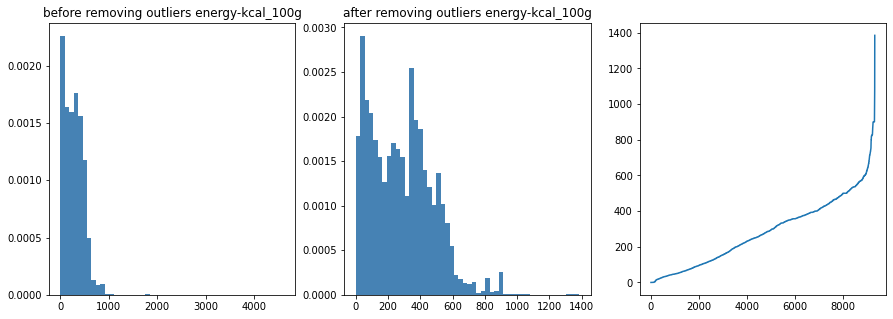

In [17]:
data2 = data.copy()
colname = "energy-kcal_100g"
possible_vals = possible_val_dict[colname]
limit_vals = limit_val_dict[colname]

fig = plt.figure(figsize=(15, 5))

## Histogramme global 
ax = fig.add_subplot(1,3,1)
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
ax.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
ax.set_title("before removing outliers " + colname)

outliers = extract_irreg_errors_val(colname,possible_vals, data = data)
print("outliers products :",np.array(data.loc[data[colname].isin(outliers), "product_name"]), "\n")
# replace outliers by np.nan : 
data2.at[data2[colname].isin(outliers)] = np.nan

## Histogramme : 
ax = fig.add_subplot(1,3,2)
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
ax.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
ax.set_title("after removing outliers " + colname)

# plot values : 
ax = fig.add_subplot(1,3,3)
ax.plot(np.sort(data2[colname]))

## Print problematic variables : 
limit_products = extract_irreg_errors_val(colname, limit_vals, data = data2)
print(" limit products :",
      np.array(data.loc[data[colname].isin(limit_products), "product_name"]))

The possible values set, let's drop the corresponding values in our dataset. 

Note that if one product has more that half of the columns with outliers, we may want to drop it, so I construct an outlier counter, and add it with the number of missing values already present.
**To be added to preprocess**

In [18]:
def preprocess2_data(possible_val_dict,data):
    count_outliers = pd.Series(data.isna().sum(axis = 1),index = data.index)
    for colname in data.columns.intersection(possible_val_dict.keys()) : 
        outliers_index = data[colname].isin(limit_products)
        count_outliers[outliers_index]+=1
        data.loc[outliers_index,colname] = np.nan
    ## drop products where to more than half missing values : 
    to_drop_products = count_outliers[count_outliers>(int(len(data.columns)/2)+1)].index
    data.drop(to_drop_products, axis = 0, inplace = True)
preprocess2_data(possible_val_dict,data)

In [19]:
data.head()

,code,creator,product_name,countries,additives_n,ingredients_from_palm_oil,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
1028220,4002861774393,twoflower,Original Schwäbische Knöpfle,Deutschland,0.0,0.0,373.0,1579.0,3.30,0.80,...,68.60,3.30,NaN,15.3,0.040,NaN,NaN,NaN,NaN,-1.0
884933,3565430000343,tacite,Douceur de Chèvre (22% MG),France,0.0,0.0,329.0,1377.0,27.00,19.00,...,1.00,0.50,NaN,20.0,0.480,NaN,NaN,NaN,NaN,14.0
1308527,7310511800307,kiliweb,Marabou Milchschokolade mit Haselnüssen,"Frankreich, United States",1.0,0.0,565.0,2364.0,37.00,17.00,...,50.00,49.00,3.3,6.5,0.112,NaN,NaN,NaN,NaN,25.0
207275,74555047520,usda-ndb-import,"La bree's bakery, chocolate mini cupcakes",United States,22.0,0.0,392.0,1640.0,18.92,6.76,...,56.76,43.24,1.4,2.7,0.311,0.000041,0.0,0.027,0.00195,21.0
1098521,4251099611004,freddii,Alete Kinderkeks Schoko,en:Germany,2.0,0.0,434.0,1816.0,11.10,3.20,...,74.00,22.00,2.6,8.0,0.060,NaN,NaN,NaN,NaN,10.0


# 6. Estimate remaining missing values

Now that we have a cleanner dataset, it is time to infer the missing values. I propose two approaches. The first one is to use automatic method implemented in the pandas library (pd.fillna, pd.interpolate). Then, as suggested in the project instructions, I infer the missing values with a KNN procedure.  

In [20]:
data2 = data.copy()

## 6.1. Pandas methods to deal with missing values

Let's first see the more naive approaches, that is filling the data with the mean :

In [21]:
## FILL WITH GLOBAL MEAN VALUE : 
data_filled_with_mean = data.fillna(data2.mean())

As the columns are not scaled, fill the missing values with mean seems not right : we'd better fill with the  column mean :

In [22]:
data_filled_with_mean = data.copy()
for colname in data.columns : 
    if pd.api.types.is_float_dtype(data[colname].dtype) : # == "float64":
        data_filled_with_mean[colname].fillna(data[colname].mean(), inplace = True)
data_filled_with_mean.head()

,code,creator,product_name,countries,additives_n,ingredients_from_palm_oil,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
1028220,4002861774393,twoflower,Original Schwäbische Knöpfle,Deutschland,0.0,0.0,373.0,1579.0,3.30,0.80,...,68.60,3.30,2.912052,15.3,0.040,0.000125,0.006803,0.145975,0.002459,-1.0
884933,3565430000343,tacite,Douceur de Chèvre (22% MG),France,0.0,0.0,329.0,1377.0,27.00,19.00,...,1.00,0.50,2.912052,20.0,0.480,0.000125,0.006803,0.145975,0.002459,14.0
1308527,7310511800307,kiliweb,Marabou Milchschokolade mit Haselnüssen,"Frankreich, United States",1.0,0.0,565.0,2364.0,37.00,17.00,...,50.00,49.00,3.300000,6.5,0.112,0.000125,0.006803,0.145975,0.002459,25.0
207275,74555047520,usda-ndb-import,"La bree's bakery, chocolate mini cupcakes",United States,22.0,0.0,392.0,1640.0,18.92,6.76,...,56.76,43.24,1.400000,2.7,0.311,0.000041,0.000000,0.027000,0.001950,21.0
1098521,4251099611004,freddii,Alete Kinderkeks Schoko,en:Germany,2.0,0.0,434.0,1816.0,11.10,3.20,...,74.00,22.00,2.600000,8.0,0.060,0.000125,0.006803,0.145975,0.002459,10.0


Ok, this first approach seems to be efficient. There are some cons to use this :
* it does not tackle the str values
* it can introduce a bias, as the columns with many missing values will be drowned to their mean. 

**It can be relevant to use this method with a clustering computed before : fill the missing data cluster by cluster mean for this column.** 

Let's now impute the missing data with interpolation.

In [23]:
## GLOBAL INTERPOLATION : 
data_filled_interpol = data.interpolate(limit_direction='both')
# data_filled_interpol.head()

In the same way, even if it is easier to do that, there are issue to make a global interpolation, as the columns are not "sorted". A clustering approach to "sort" the data may improve this. 
Furthermore, the first and last lines are not imputed if the attribute 
`limit_direction='both'` is not set : **we can also think about a shuffle method**.

## 6.2. KNN inference : 

The main issues in the method that I propose before is a question of order : I is arbitrary ordered and the imputation depends strongly on that order. To get rid of this, I use a KNN. That is the missing data are computed comparing the product with the k products that the most similar in the dataset sample.


In [24]:
from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors


### 6.2.1 sklearn.impute.KNNImputer 

In the sklearn library, a function does exactly what I want to do. I used the [linked tutorial](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/) as a support for this part :

In [25]:
from sklearn.impute import KNNImputer
from numpy import isnan

X = data[data.columns.intersection(float_var)]

print('Total Missing values : %d' % sum(isnan(X.values).flatten()))
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X)
Xtrans = imputer.transform(X)
print('Remaining Missing values : %d' % sum(isnan(Xtrans).flatten()))

Total Missing values : 49705
Remaining Missing values : 0


In the tutorial, they compare this method with a random forest classifer, and use an accuracy score to compare the results. I wanted to do "simpler" thing and just do a cross validation. The issue is the missing values in X (that is what I and trying to solve)! They prevent me to use the "r2" score, or any score in sklearn.metrics because of these missing values. I see two ways to work around this : 

* fill missing values with column mean values in X, and infer better y, but to do so, I'll need to decompose the treatment column by column
* pop some known data in the data set (replace with `np.nan`), to be able to compare the predicted result with the real one, using a $R^2$ score for example. That means I have to compute this $R^2$ score, such that it ignores the original missing values. 

<!-- As I don't have the time to do both, I choose the  idea (which seems more simpler) :  -->

In [26]:
dropna = True

def my_mean(y) : 
    return np.mean(y[~np.isnan(y)])

def my_norm2(x,y, dropna = False):
    res = (x - y)**2
    if dropna : 
        res = res[~np.isnan(res)]
    res = np.sum(res)
    return np.sqrt(res)
    
def my_r2score(pred, target, dropna=False):
    SSR = my_norm2(pred, target, dropna)
    SST = my_norm2(target, my_mean(target),dropna)
    return 1 - SSR / SST 

X will be the data with only numerical variables :

In [27]:
## only consider float variables : 
X = data[data.columns.intersection(float_var)]
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X), 
                 columns= X.columns, index = X.index)
## train = X with 20% random dropped
index_to_drop = np.random.choice([True,False], size = X.shape, p=[0.3,0.7])
train = X.copy() 
train.values[index_to_drop]= np.nan  
## target = X : we compare the 20% missing values predicted
target = X.copy()

As we are dealing with some picked entries, we better work calling these entries and flat the data. 

In [28]:
## pred = prediction of missing vals in X (all missing values)
impute_pred = KNNImputer(n_neighbors=2).fit_transform(train)
pred = pd.DataFrame(impute_pred, columns = X.columns, index = X.index)

flat_drop_index = index_to_drop.flatten()

flat_pred = pred.values.flatten()[flat_drop_index]
flat_target = target.values.flatten()[flat_drop_index]

my_r2score(flat_pred, flat_target, dropna = True)

-0.09230753987828533

I just need to define this score as a scikit-learn score :

In [29]:
# from sklearn.metrics import make_scorer
# my_r2_score = make_scorer(my_r2score, greater_is_better=True)

Now, I have all the elements to make a cross validation. I cannot call GridSearchCV as it stands, because the `y` element is missing. **It is not that simple to compute the imputer with a flatten res, that is still a sklearn estimator, though it could be a good exercice**

I went to the [source code of the sklearn KNNImputer](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/impute/_knn.py#L19) and the [way regressors are implemented in sklearn](https://scikit-learn.org/stable/developers/develop.html), to see how to adapt the existing method for my problem. It is feasable, but the main issue is that we compare some elements of the matrix, and it is not that easy to pass them in a flat function while separating the training set into folds ! I have the ideas, but I don't think I have the time to implement it for the moment. 

Furthermore, I have an other idea to get around this problem, as I implemented my own CV 
[in a practical lesson of the OC class](https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/6737946-entrainez-vous-selectionnez-le-nombre-de-voisins-dans-un-knn-pour-une-regression)
, I can take 
[that code](https://github.com/ClaireGayral/formation_openclassroom/blob/master/cours_inge_ML/2_Evaluez_les_perf_d_un-modele_de_ML/TPchapitre2_reecrire_CV_reg.ipynb) 
and modify it easily. 
For each "fold", I extract the corresponding X_train, and I randomly extract 1% of the values, and drop them :
* flat_target = vector of the flattened extracted values (that can be nans)
* train = data with the missing values (contained in y_train)
* flat_pred = vector of the flattened predicted values (the same index than from y_train) 

Note that it is not really a CV, as the folds are just some values randomly dropped.

In [31]:
def define_drop_index(shape,drop_proportion) : 
    return np.random.choice([True,False], size = shape, p=[drop_proportion,1-drop_proportion])

index_to_drop = define_drop_index(X.shape,0.3)

def get_missing_flat(X, index_to_drop):
    # X is pd.DataFrame
    # index_to_drop is the result of define_drop_index
    # returns the vector (from flat) of the dropped data  
    flat_drop_index = index_to_drop.flatten()
    return X.values.flatten()[flat_drop_index]
    
## EXTRACT X_train, y_train and y_pred FROM X AND index_to_drop : 
def drop_from_index(X, index_to_drop): 
    # X is pd.DataFrame
    # index_to_drop is the result of define_drop_index
    # returns the pd.DataFrame X with dropped data
    ## drop :
    train = X.copy() 
    train.values[index_to_drop]= np.nan 
    return train 

## an example of use : 
# train = drop_from_index(X, index_to_drop)
# flat_target = get_missing_flat(X, index_to_drop)
# my_meth = KNNImputer()
# pred = my_meth.fit_transform(train)
# pred = pd.DataFrame(pred, index = X.index, columns = X.columns)
# flat_pred = get_missing_flat(pred, index_to_drop)


In [32]:
my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,30,2)}
cv = 5

def launch_my_pseudo_CV(X,my_meth,param_grid, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    for kwargs in param_dirg :
        params_set = "_".join(str(val) for val in kwargs.values())
        res[params_set]={}

    ## SET FOLDS : they are not folds, but repetition of the procedure
    ### LOOP ON FOLDS :
    for k_iter in range(cv) : 
        index_to_drop = define_drop_index(X.shape,0.3)   
        train = drop_from_index(X, index_to_drop)
        flat_target = get_missing_flat(X, index_to_drop)
        
        ### LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        for kwargs in param_dirg :
            ## SET PARAMS IN METH :
            CV_meth = my_meth(**kwargs)
            ## PREDICT MISSING VALUES : 
            pred = CV_meth.fit_transform(train)
            pred = pd.DataFrame(pred, index = X.index, columns = X.columns)
            flat_pred = get_missing_flat(pred, index_to_drop)
            y_table = pd.DataFrame(np.matrix((flat_pred, flat_target)).T, columns=["pred","real"])
            ## SAVE :             
            params_set = "_".join(str(val) for val in kwargs.values())
            res[params_set][fold_key] = y_table
    return res

res = launch_my_pseudo_CV(X,my_meth,param_grid, cv = 5)

In [ ]:
res

**how to save dict of different type, such as res ?**

In [33]:
### INTEGRATING SCORES ON TABLE :
def compute_MSE(table):
    return my_norm2(table.real,table.pred)

def compute_dict_MSE(tables):
    mse_vect = []
    for key, value in tables.items():
        mse_vect.append(compute_MSE(value))
    return np.array(mse_vect)

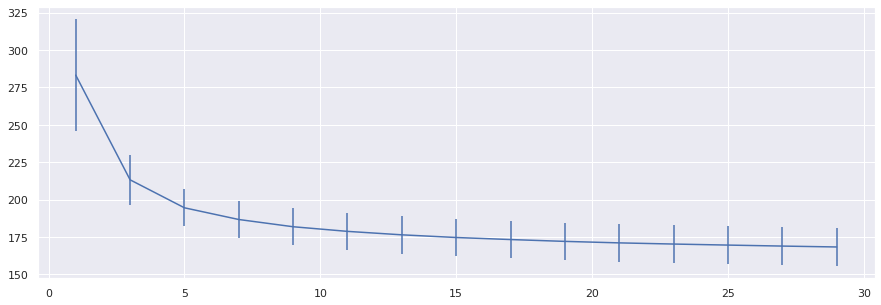

In [80]:
fig, ax = plt.subplots()
ax.errorbar(x=np.arange(1,30,2), y=np.array(CV_results_["mean_MSE_score"]),
            xerr=0, yerr=np.array(CV_results_["std_MSE_score"]))
plt.show()

In [35]:
my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,50,1)}
cv = 5

res2 = launch_my_pseudo_CV(X,my_meth,param_grid, cv = 5)

In [37]:
res = res2

In [38]:
MSE_mean = []
MSE_std = []

for params_set in res.keys(): 
    dict_y_table = res[params_set]
    
    MSE = compute_dict_MSE(dict_y_table)
    MSE_mean.append(MSE.mean())
    MSE_std.append(MSE.std())

params = []
for kwargs in model_selection.ParameterGrid(param_grid) :
    params.append(kwargs)

CV_results_ = {"params": params , "mean_MSE_score":MSE_mean, "std_MSE_score":MSE_std}


## new syntax to iterate <3 <3 : 
iterator = zip(CV_results_["mean_MSE_score"], CV_results_["std_MSE_score"], CV_results_["params"])
for mean, std, params in iterator:
    print("MSE = %0.3f (+/-%0.3f) for %s" %(mean, 2*std, params))


MSE = 275.544 (+/-113.879) for {'n_neighbors': 1}
MSE = 226.327 (+/-54.206) for {'n_neighbors': 2}
MSE = 208.963 (+/-39.944) for {'n_neighbors': 3}
MSE = 201.085 (+/-37.421) for {'n_neighbors': 4}
MSE = 192.885 (+/-25.970) for {'n_neighbors': 5}
MSE = 187.512 (+/-19.350) for {'n_neighbors': 6}
MSE = 184.179 (+/-16.724) for {'n_neighbors': 7}
MSE = 181.044 (+/-13.472) for {'n_neighbors': 8}
MSE = 178.569 (+/-11.176) for {'n_neighbors': 9}
MSE = 176.643 (+/-9.732) for {'n_neighbors': 10}
MSE = 174.979 (+/-8.761) for {'n_neighbors': 11}
MSE = 173.662 (+/-8.125) for {'n_neighbors': 12}
MSE = 172.530 (+/-7.752) for {'n_neighbors': 13}
MSE = 171.449 (+/-7.421) for {'n_neighbors': 14}
MSE = 170.585 (+/-7.382) for {'n_neighbors': 15}
MSE = 169.770 (+/-7.311) for {'n_neighbors': 16}
MSE = 168.999 (+/-7.269) for {'n_neighbors': 17}
MSE = 168.309 (+/-7.280) for {'n_neighbors': 18}
MSE = 167.746 (+/-7.287) for {'n_neighbors': 19}
MSE = 167.131 (+/-7.310) for {'n_neighbors': 20}
MSE = 166.642 (+/-7

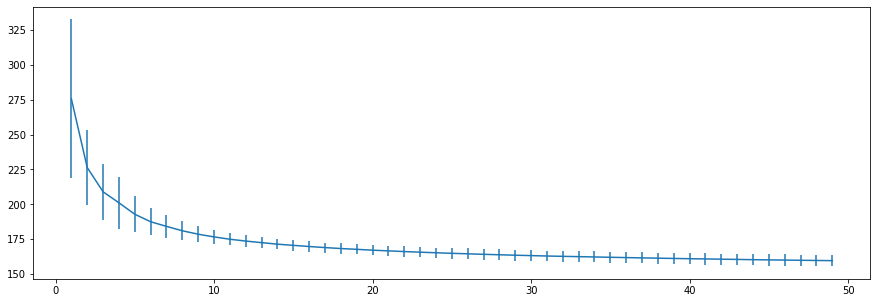

In [40]:
fig, ax = plt.subplots()
ax.errorbar(x=np.arange(1,50,1), y=np.array(CV_results_["mean_MSE_score"]),
            xerr=0, yerr=np.array(CV_results_["std_MSE_score"]))
plt.show()

`n_neighbors = 10` seems to be a good fit : 

In [41]:
n_neighbors = 10

### 6.2.2 Idea 2 : fill nans with mean column val and knn estimate the remaining 

The methodology is the following. For each column : 
1. I need to separate the index with nan (that is the one I want to infer) from the rest.
2. Then I need to separate a train and test sample, and standardize the X data. 
3. Then compute a Cross Validation to set the better `n_neighbors` parameter (that is the number of neighbors)
4. I use this best fitted param to train my model on X[y==NaN] and predict the corresponding missing values.

In [42]:
## X is already standardized :
colname = "nutrition-score-fr_100g"

##
## 1. SEPARATE INDEX WITH AND WITHOUT NANs IN y : 
## 
index_without_nans_y = ~data[colname].isna()
y = data.loc[index_without_nans_y, colname]
X = data.loc[index_without_nans_y, np.setdiff1d(data.columns.intersection(float_var).values,[colname])]

##
## 2. SPLIT SAMPLE TRAIN-TEST AND STANDARD : 
## 


##
## 3. COMPUTE CV AND EXTRACT BEST PARAM
##
n_neighbors = 10 


# 6.3. Compute the imputation and save data :

In [49]:
X = data[data.columns.intersection(float_var)]
## STANDARDIZE : 
standardizer = preprocessing.StandardScaler()
standardizer.fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)
## IMPUTE :
imputer = KNNImputer(n_neighbors=10)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## INVERSE-STANDARDIZE : 
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


In [56]:
pred.to_csv(data_path+"projet2/cleanned_dataframe.csv")
pred_std.to_csv(data_path+"projet2/cleanned_std_dataframe.csv")

In [55]:
df = pd.read_csv(data_path+"projet2/cleanned_dataframe.csv",  index_col =0)
df

,additives_n,ingredients_from_palm_oil,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
1028220,0.0,0.0,373.0,1579.0,3.30,0.80,-6.938894e-18,0.0390,68.60,3.30,3.020,15.30,0.040,0.000054,0.00000,0.0433,0.003191,-1.0
884933,0.0,0.0,329.0,1377.0,27.00,19.00,-6.938894e-18,0.0889,1.00,0.50,0.050,20.00,0.480,0.000296,0.00000,0.6250,0.000714,14.0
1308527,1.0,0.0,565.0,2364.0,37.00,17.00,-6.938894e-18,1.1056,50.00,49.00,3.300,6.50,0.112,0.000025,0.00140,0.1550,0.002617,25.0
207275,22.0,0.0,392.0,1640.0,18.92,6.76,0.000000e+00,0.0340,56.76,43.24,1.400,2.70,0.311,0.000041,0.00000,0.0270,0.001950,21.0
1098521,2.0,0.0,434.0,1816.0,11.10,3.20,-6.938894e-18,0.0000,74.00,22.00,2.600,8.00,0.060,0.000074,0.00575,0.0169,0.002727,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179908,5.0,0.0,400.0,1674.0,5.71,0.00,0.000000e+00,0.0000,82.86,22.86,5.700,5.71,0.429,0.000171,0.00325,0.1000,0.002860,8.0
245051,1.0,0.0,393.0,1644.0,32.14,17.86,0.000000e+00,0.1070,3.57,0.00,0.000,25.00,0.607,0.000321,0.00000,0.7140,0.000000,15.0
1029557,1.0,0.0,529.4,2229.0,33.00,2.60,-6.938894e-18,0.0000,50.00,2.80,5.433,5.40,0.800,0.000028,0.00526,0.0271,0.001225,16.0
501037,0.0,0.0,128.0,536.0,6.20,2.50,-6.938894e-18,0.0626,0.50,0.00,0.000,17.80,0.072,0.000010,0.00095,0.0159,0.001326,-2.0


**Ce qu'il resterait à faire pour améliorer le notebook :** 

* appeler les données via l'API json serait bien plus classe, et ça me plairait d'apprendre à faire ce genre de choses.
* traiter des variables textes (complètement laissées à l'abandon).
* écrire une classe pour le traitement de ce jeu de données, avec une partie prétraitement, et une partie analyse qui irait avec le notebook suivant.
* dans l'imputation, faire un post-traitement pour rendre entier les valeurs manquantes dans les colonnes où il faudrait (comme dans la colonne "n_additives"). Pour le moment, disons que l'on peut vivre avec des flottants + essayer la méthode d'imputation moyenne par cluster